<a href="https://colab.research.google.com/github/Zilch123/AgentAssistance/blob/main/QTable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
from random import randint
from scipy import stats
from collections import deque
plt.rcParams.update({'font.size': 18})
from IPython.display import clear_output
import matplotlib as mpl
from IPython.core.display import Video
plt.rcParams['figure.figsize'] = [5, 3]
mpl.rcParams['animation.convert_path'] = r'/usr/bin/convert'

In [47]:
# Gridworld example class and helper functions

class gridworld:
    
    def __init__(self):
        self.dim = [4, 4]
        self.pos_goal = [3, 3]
        self.rew_goal = 10
        self.pos_trap = [2, 2]
        self.rew_trap = -5
        # Define starting position
        self.start = [0, 0]
        self.s = self.start[:]
        self.complete = False
            
        # Step count
        self.n = 0
        self.action_space = [0, 1, 2, 3, 4, 5, 6, 7]
        self.action_dict = {'Up': 0,
                           'UpLeft':1,
                           'Left':2,
                           'DownLeft':3,
                           'Down':4,
                           'DownRight':5,
                           'Right':6,
                           'UpRight':7}
        self.action_prob = [0.125, 0.125, 0.125, 0.125,
                            0.125, 0.125, 0.125, 0.125]

    # Show empty selfironment
    def show_grid(self):
        # print rows
        for i in range(self.dim[0]):
            print("-" * (self.dim[1] * 5 + 1))
            row = []
            for j in range(self.dim[1]):
                if i == self.pos_goal[0] and j == self.pos_goal[1]:
                    row.append("| G ")
                elif i == self.pos_trap[0] and j == self.pos_trap[1]:
                    row.append("| T ")
                elif i == self.start[0] and j == self.start[1]:
                    row.append("| S ")
                else:
                    row.append("|   ")
            row.append("|  ")
            print(' '.join(row))
        print("-" * (self.dim[1] * 5 + 1))
        
    # Show state
    def show_state(self):
        # print rows
        for i in range(self.dim[0]):
            print("-" * (self.dim[1] * 5 + 1))
            row = []
            for j in range(self.dim[1]):
                if i == self.s[0] and j == self.s[1]:
                    row.append("| X ")
                elif i == self.pos_goal[0] and j == self.pos_goal[1]:
                    row.append("| G ")
                elif i == self.pos_trap[0] and j == self.pos_trap[1]:
                    row.append("| T ")
                else:
                    row.append("|   ")
            row.append("|  ")
            print(' '.join(row))
        print("-" * (self.dim[1] * 5 + 1))
        
    # Give the agent an action
    def step(self, a):
        if a not in self.action_space:
            return "Error: Invalid action submission"
        # Check for special terminal states
        if self.s == self.pos_goal:
            self.complete = True
            reward = self.rew_goal
        elif self.s == self.pos_trap:
            # Move up 0 
            if a == 0 and self.s[0] > 0:
                self.s[0] -= 1
            # Move Up Left
            elif a == 1 and self.s[0] > 0 and self.s[1]>0:
                self.s[0] -= 1
                self.s[1] -= 1
            # Move left
            elif a == 2 and self.s[1] > 0:
                self.s[1] -= 1
            # Move Down Left
            elif a== 3 and  self.s[0] < self.dim[0] - 1 and self.s[1] > 0:
                self.s[0] += 1
                self.s[1] -= 1
            # Move down
            elif a == 4 and self.s[0] < self.dim[0] - 1:
                self.s[0] += 1
            # Move Down Right
            elif a== 5 and  self.s[0] < self.dim[0] - 1 and self.s[1] < self.dim[1] - 1:
                self.s[0] += 1
                self.s[1] += 1
            # Move right
            elif a == 6 and self.s[1] < self.dim[1] - 1:
                self.s[1] += 1
            # Move Up Right 
            elif a== 7 and self.s[0]>0 and self.s[1] < self.dim[1] - 1:
                self.s[0] -= 1
                self.s[1] += 1
            reward = self.rew_trap
        else:
            # Move up 0 
            if a == 0 and self.s[0] > 0:
                self.s[0] -= 1
            # Move Up Left
            elif a == 1 and self.s[0] > 0 and self.s[1]>0:
                self.s[0] -= 1
                self.s[1] -= 1
            # Move left
            elif a == 2 and self.s[1] > 0:
                self.s[1] -= 1
            # Move Down Left
            elif a== 3 and  self.s[0] < self.dim[0] - 1 and self.s[1] > 0:
                self.s[0] += 1
                self.s[1] -= 1
            # Move down
            elif a == 4 and self.s[0] < self.dim[0] - 1:
                self.s[0] += 1
            # Move Down Right
            elif a== 5 and  self.s[0] < self.dim[0] - 1 and self.s[1] < self.dim[1] - 1:
                self.s[0] += 1
                self.s[1] += 1
            # Move right
            elif a == 6 and self.s[1] < self.dim[1] - 1:
                self.s[1] += 1
            # Move Up Right 
            elif a== 7 and self.s[0]>0 and self.s[1] < self.dim[1] - 1:
                self.s[0] -= 1
                self.s[1] += 1

            reward = -1
        self.n += 1
        return self.s, reward, self.complete
            
    def reset(self):
        self.s = self.start[:]
        self.complete = False
        self.n = 0
        return self.s, self.pos_goal, self.dim, self.pos_trap

    # Plots policy from q-table
    def plot_policy(self, q_table, figsize=(12,8), title='Learned Policy'):
        x = np.linspace(0, self.dim[1] - 1, self.dim[1]) + 0.5
        y = np.linspace(self.dim[0] - 1, 0, self.dim[0]) + 0.5
        X, Y = np.meshgrid(x, y)
        zeros = np.zeros(self.dim)

        fig = plt.figure(figsize=figsize)
        ax = plt.axes()
        # Get max values
        q_max = q_table.max(axis=2)
        for i in range(self.dim[0]):
            for j in range(self.dim[1]):
                q_star = np.zeros(self.dim)
                q_max_s = q_max[i, j]
                max_vals = np.where(q_max_s==q_table[i,j])[0]
                for action in max_vals:
                    q_star[i,j] = 0.4
                    # Plot results
                    if action == 0:
                        # Move up
                        plt.quiver(X, Y, zeros, q_star, scale=1, units='xy')
                    elif action == 1:
                        # Move left
                        plt.quiver(X, Y, -q_star, zeros, scale=1, units='xy')
                    elif action == 2:
                        # Move down
                        plt.quiver(X, Y, zeros, -q_star, scale=1, units='xy')
                    elif action == 3:
                        # Move right
                        plt.quiver(X, Y, q_star, zeros, scale=1, units='xy')
                        
        plt.xlim([0, self.dim[1]])
        plt.ylim([0, self.dim[0]])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        plt.title(title)
        plt.grid()
        plt.show()

In [48]:
np.random.seed(1234)
def map_(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min;

In [49]:
env = gridworld()
env.show_grid()

---------------------
| S  |    |    |    |  
---------------------
|    |    |    |    |  
---------------------
|    |    | T  |    |  
---------------------
|    |    |    | G  |  
---------------------


In [50]:
q_table = np.zeros((env.dim[0], env.dim[1], len(env.action_space)))
q_table.shape

(4, 4, 8)

In [51]:

# Parameters
num_episodes = 600    # Number of episodes 
gamma = 0.99          # 1 - Future reward Vs 0 - immediate reward 
eps = 0.05            # Exploration Vs Exploitation (esp--> % of exploration)  
lr = 0.01             # Learning rate 1--> Only recent  0 makes the agent learn nothing (exclusively exploiting prior knowledge)

# Calculating Q Table

Learning Rate: to what extent newly acquired information overrides old information


Discount Rate: diminish or increase the contribution of future rewards

[Source](https://en.wikipedia.org/wiki/Q-learning#Learning_Rate)

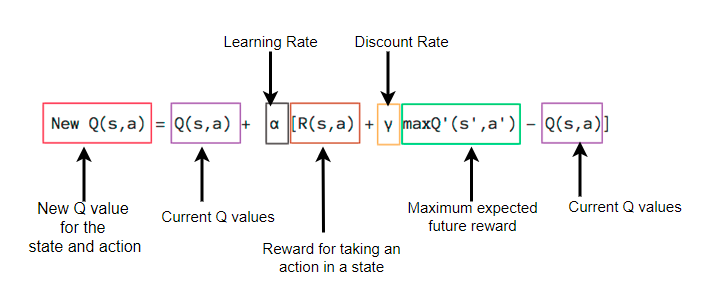

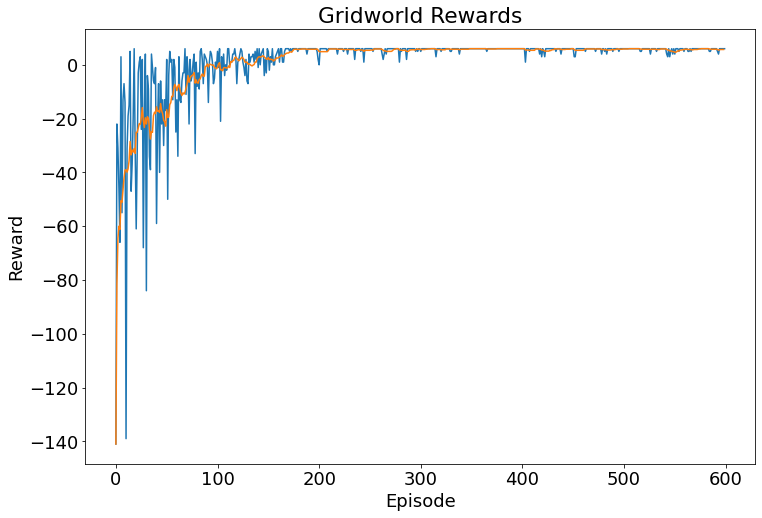

In [52]:
ep_rewards = []
n_steps = []

q_table = np.zeros((env.dim[0], env.dim[1], len(env.action_space)))

for ep in range(num_episodes):
    data = env.reset()
    s_0 = data[0]
    done = False
    rewards = 0
    while done == False:
        if np.random.rand() < eps: #eps= 0.05 np.random.rand() ---> [0, 1)                        
            # Random Action 5% of the time
            action = np.random.choice(env.action_space)      
        else:
            # Deterministic Action- max q value
            action = np.argmax(q_table[s_0[0], s_0[1]])       
            
        s_1, reward, done = env.step(action)  
        # s_1 ---> State after action 
        # s_0 ===> Current state

        q_table[s_0[0], s_0[1], action] += lr*(reward + \
                                               gamma*np.max(q_table[s_1[0], s_1[1]]) \
                                               - q_table[s_0[0], s_0[1], action])
        
        s_0 = s_1.copy()
        rewards += reward
        if done:
            ep_rewards.append(rewards)
            
# rolling average
mean_rewards = [np.mean(ep_rewards[n-10:n]) if n > 10 else np.mean(ep_rewards[:n]) 
               for n in range(1, len(ep_rewards))]

# Plot results
plt.figure(figsize=(12,8))
plt.plot(ep_rewards)
plt.plot(mean_rewards)
plt.title('Gridworld Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()


# Visual Representation 

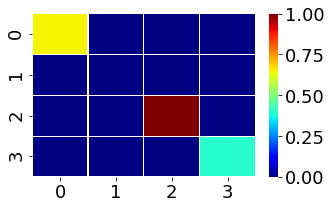

In [56]:
#@title Default title text
o=0
table__={}
num_episodes = 1
dim = data[2]
pos_goal = data[1]
pos_trap = data[3]
table = np.zeros(dim)
table[pos_goal[0],pos_goal[1]] = 0.4
table[pos_trap[0],pos_trap[1]] = 1.0
for ep in range(num_episodes):
    data = env.reset()
    s_0 = data[0]
    done = False
    rewards = 0
    while done == False:
        action = np.argmax(q_table[s_0[0], s_0[1]])       # Deterministic Action- max q value
        if(s_0==pos_goal):
            table[s_0[0], s_0[1]] = .65
        else:
            table[s_0[0], s_0[1]] = .65
        table__[str(o)] = table.copy()
        o = o + 1
        table[s_0[0], s_0[1]] = 0.0
        s_1, reward, done = env.step(action)
        rewards += reward
        if done:
            ep_rewards.append(rewards)

# Animation part 
def update_frame(i):
    plt.clf()
    heatmap_data = table__[str(i)]
    ax = sns.heatmap(
        heatmap_data,
        annot=False,
        cmap='jet',
        linewidths=.05,
        fmt='')

fig = plt.figure()
data_min = np.nanmin(table__.values)
data_max = np.nanmax(table__.values)
data_frames_iterator = table__.values()
# write animation frames
anim = animation.FuncAnimation(fig, update_frame, frames=len(table__), interval=100)
# anim.save('test.gif', writer='imagemagick')
HTML(anim.to_html5_video())